In [1]:
import numpy as np
import os
import sys
from os import listdir
from os.path import isfile, join, exists, split
import matplotlib.pyplot as plt
import time
import nibabel as nib
#import cortex
import importlib

import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

#from helpers import helpers

#importlib.reload(helpers)

In [7]:
sub = 'sub-001'
session = 'ses-03'

# bids directory
homedir = '/jukebox/norman/rsiyer/rtmindeye/data_correct/bids'

# datadir is fmriprep folder for this subject, outputdir is glmsingle derivatives
datadir = join(homedir,'derivatives','fmriprep',sub)
maskdir = join(homedir,'derivatives','masks', sub)
designdir = '/jukebox/norman/rsiyer/rtmindeye/data/design/'
outputdir = join(homedir,'derivatives','glmsingle/')
ses_dir = join(datadir,session,'/','func/')
defaced_dir = join(homedir,'derivatives','deface/')
loaddir = join(homedir,'derivatives','glmsingle',sub)

In [8]:
#Load brain mask
file_in = maskdir + '/%s_%s_brain.nii.gz' % (sub, session)
print('Loading average brain mask:', file_in)
avg_mask=nib.load(file_in)

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {np.sum(brain)} voxels in the included brain mask\n')

Loading average brain mask: /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/masks/sub-001/sub-001_ses-03_brain.nii.gz
Mask dimensions: (1.8, 1.8, 1.8)

Affine:
[[  1.79999995   0.           0.         -71.30000305]
 [  0.           1.79999995   0.         -78.40000153]
 [  0.           0.           1.79999995 -47.80000305]
 [  0.           0.           0.           1.        ]]

There are 185890.0 voxels in the included brain mask



In [9]:
# get some info about epi data by loading study run 1
epi_file=f'{datadir}/{session}/func/{sub}_{session}_task-study_run-01_space-T1w_desc-preproc_bold.nii.gz'
epi_data=nib.load(epi_file)
run1=epi_data.get_fdata()

print('checking epi data for run 1:', epi_file)
print('')
epi_dimsize=epi_data.header.get_zooms()
epi_affine=epi_data.affine
print('Dimensions:', epi_dimsize)
print('Affine:')
print(epi_data.affine)
print('')

# get shape of data volume (XYZ) for convenience
xyz = run1.shape[:3]
xyzt = run1.shape
print(xyz)
print(xyzt)

# double check that brain mask and epi data have same dimensions and affine
assert avg_mask.header.get_zooms() == epi_dimsize[:3]
assert avg_mask.affine.all() == epi_data.affine.all()

checking epi data for run 1: /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/fmriprep/sub-001/ses-03/func/sub-001_ses-03_task-study_run-01_space-T1w_desc-preproc_bold.nii.gz

Dimensions: (1.8, 1.8, 1.8, 1.8)
Affine:
[[  1.79999995   0.           0.         -71.30000305]
 [  0.           1.79999995   0.         -78.40000153]
 [  0.           0.           1.79999995 -47.80000305]
 [  0.           0.           0.           1.        ]]

(78, 102, 78)
(78, 102, 78, 156)


In [10]:
datasets = ['v1'] #glmsingle versions

info = dict()
info['v1'] = dict()
info['v1']['subjs'] = ['sub-001']
info['methods'] = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']


In [11]:
reliability = dict()

#masks = np.load('masks.npy',allow_pickle=True).item() 

# check to be sure all the datafiles exist
for ds in datasets:
    
    reliability[ds] = dict()
    
    for subj in info[ds]['subjs']:
        
        subj_version_list = []
        
        reliability[ds][subj] = dict()

        # load this versions's data
        if ds == 'v1':    
            temp = np.load(join(loaddir,'voxel_reliabilities_NSDgeneral.npy')) 
            method_list = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']
        
        for method in method_list:
            if method == 'assumehrf':
                idx=0
            elif method == 'fithrf':
                idx=1
            elif method == 'fithrf_glmdenoise':
                idx=2
            elif method == 'fithrf_glmdenoise_rr':
                if ds == 'v3':
                    idx=2
                else:
                    idx=3

            rel = temp[idx]
            #rel = np.load(metric_savefn)
                    
            #mask = masks[ds][subj]==1
            
            #if np.ndim(rel) == 3:
                #rel = rel[mask==1]
                
            print(ds,method,subj,rel.shape)
            
            reliability[ds][subj][method] = rel
            
            subj_version_list.append(rel)
                       
        reliability[ds][subj]['mean'] = np.mean(np.stack(subj_version_list,axis=1),axis=1)
        
        

v1 assumehrf sub-001 (25069,)
v1 fithrf sub-001 (25069,)
v1 fithrf_glmdenoise sub-001 (25069,)
v1 fithrf_glmdenoise_rr sub-001 (25069,)


In [12]:
# # iterate through datasets

# for ds in ['NSD','B5K']:
    
#     if ds == 'NSD':
#         subjs = [f'subj0{n}' for n in range(1,5)]
#     else:
#         subjs = [f'CSI{n}' for n in range(1,5)]
        
#     for subj in subjs:
        
#         plot_data = reliability[ds][subj]['fithrf_glmdenoise_rr'] - reliability[ds][subj]['assumehrf']
        
#         plot_data = helpers.reshape_nsdgeneral_to_volume(plot_data, masks[ds][subj])
        
#         plot_data[masks[ds][subj] < 1] = 0
        
#         _ = helpers.plot_flat_map(ds, subj, plot_data, title = f'', 
#                           cmap = 'RdBu_r', vmin = -0.2, vmax = 0.2, colorbar=False)
        

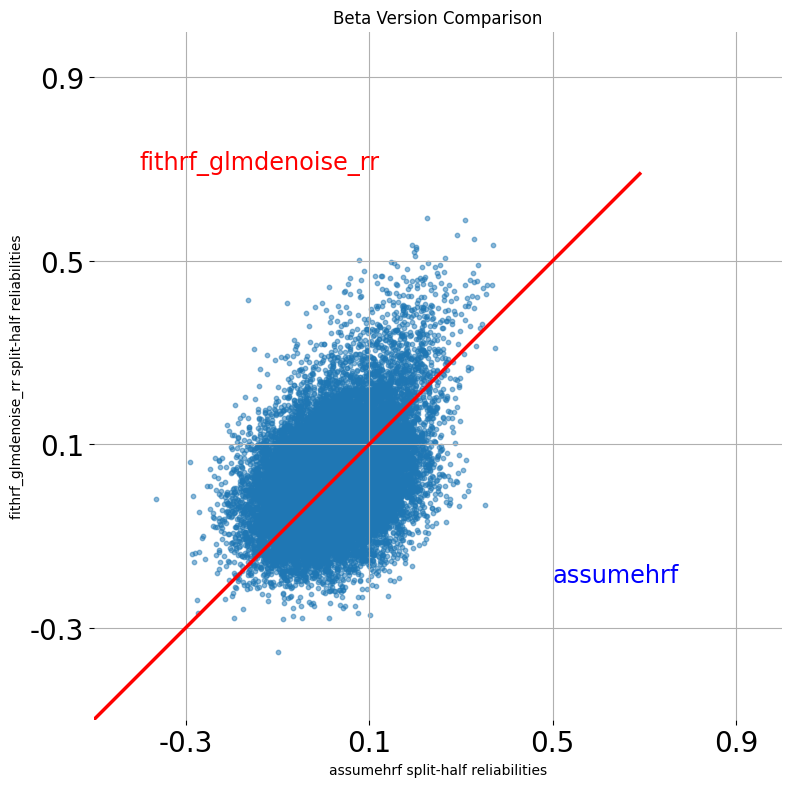

In [56]:
draw_plots = True

if draw_plots: 
    
    x_version = 'assumehrf'
    y_version = 'fithrf_glmdenoise_rr'

    # iterate through datasets
    for ds in datasets:
        for subj in info[ds]['subjs']:

            #x = helpers.reshape_nsdgeneral_to_volume(reliability[ds][subj][x_version], masks[ds][subj])
            #y = helpers.reshape_nsdgeneral_to_volume(reliability[ds][subj][y_version], masks[ds][subj])
            x = reliability[ds][subj][x_version]
            y = reliability[ds][subj][y_version]

            #x[masks[ds][subj] < 1] = np.nan
            #y[masks[ds][subj] < 1] = np.nan

            plt.figure(figsize=(8,8))
            plt.grid('on')
            plt.scatter(x, y, 10, alpha = 0.5)
            plt.axis('square')

            plt.plot(np.arange(-0.6,0.7,0.01),np.arange(-0.6,0.7,0.01),'r',linewidth=2.5,zorder=10)

            if ds == 'mindeye':
                ticks = (-0.3,0.8,0.4)
            else:
                ticks = (-0.3,1,0.4)

plt.xticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
           np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=20)
plt.yticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
           np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=20)

plt.xlabel(f"{x_version} split-half reliabilities")
plt.ylabel(f"{y_version} split-half reliabilities")
plt.title('Beta Version Comparison')

plt.text(0.5, -0.2, x_version, color='blue', fontsize='xx-large')
plt.text(-0.4, 0.7, y_version, color='red', fontsize='xx-large')

if ds == 'mindeye':
    plt.xlim([-0.5,0.75])
    plt.ylim([-0.5,0.75])
else:
    plt.xlim([-0.5,1])
    plt.ylim([-0.5,1])

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [32]:
y.shape

(25069,)

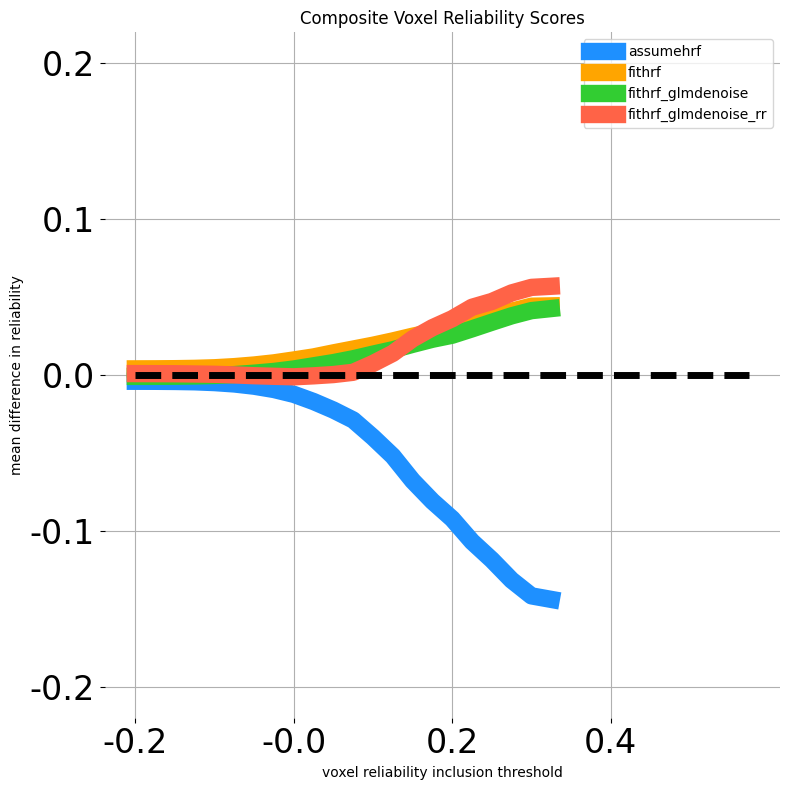

In [25]:
ft = 16

versions = ['assumehrf','fithrf','fithrf_glmdenoise','fithrf_glmdenoise_rr']
colors = ['dodgerblue','orange','limegreen','tomato']

bins  = np.round(np.arange(-0.2,0.6,0.025),3)

method = 'mean'
min_nvox = 100

allsubj_diffs = dict()

# iterate through datasets
for ds in ['v1']:
    
    allsubj_diffs[ds] = dict()
    
    for version in versions:
        allsubj_diffs[ds][version] = []

    # iterate through subjects
    for subj in info[ds]['subjs']:
                
        plt.figure(figsize=(8,8))
        
        subj_mean_metric = reliability[ds][subj]['mean']
        
        subj_version_diffs = []
        
        # iterate through versions
        v=0
        for version in versions:
            
            this_version = reliability[ds][subj][version]
            this_version_diffs = []
            this_version_stds = []
            for val in bins:
           
                validvox = subj_mean_metric > val
                
                if np.sum(validvox) > min_nvox:
                    if method == 'mean':
                        this_version_diffs.append(np.nanmean(this_version[validvox] - subj_mean_metric[validvox]))
                    elif method == 'median':
                        this_version_diffs.append(np.nanmedian(this_version[validvox] - subj_mean_metric[validvox]))
                    this_version_stds.append(np.nanstd(this_version[validvox] - subj_mean_metric[validvox]))
                else:
                    this_version_diffs.append(np.nan)
                    this_version_stds.append(np.nan)
                    
            
            subj_version_diffs.append(this_version_diffs)
            plt.plot(this_version_diffs,linewidth=12.5,color = colors[v],alpha=1)
            
            v+=1
            
            allsubj_diffs[ds][version].append(this_version_diffs)
        
        plt.plot(np.zeros((len(bins),)),'k--',linewidth=5)
        plt.xticks(np.arange(len(bins))[::8],np.array(bins[::8]),fontsize=ft);
        
        plt.yticks(np.round(np.arange(-0.2,0.3,0.1),2),np.round(np.arange(-0.2,0.3,0.1),2),fontsize=33)
        plt.ylim([-0.22,0.22])
      
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.xlabel('voxel reliability inclusion threshold')
        plt.ylabel('mean difference in reliability')
        plt.title('Composite Voxel Reliability Scores')
        
        plt.grid('on')        
        plt.legend(versions)
        # get rid of the frame
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        plt.tight_layout()
        plt.show()

In [ ]:
# the next two cells are commented out because they were originally used by Jacob Prince and has some hard-coded things that we didn't need for their "version 3". We only had one version of GLMSingle per session. - Rishab Iyer

In [ ]:
# ft = 16
# #versions = ['assumehrf','fithrf','fithrf_glmdenoise','fithrf_glmdenoise_rr']
# versions = ['assumehrf','fithrf','fithrf_glmdenoise_rr']
# colors = ['dodgerblue','orange','tomato']

# bins  = np.round(np.arange(-0.2,0.6,0.02),3)

# measure = 'mean'
# min_nvox = 50

# allsubj_diffs = dict()

# for ds in datasets:
#     allsubj_diffs[ds] = dict()
#     for method in versions:
#         allsubj_diffs[ds][method] = []

# plt.figure(figsize=(12,12))
# c = 1

# # iterate through datasets
# for ds in ['v3']:
            
#     # iterate through subjects
#     for subj in info[ds]['subjs']:
        
#         plt.subplot(len(ds),2,c)
        
#         subj_mean_metric = reliability[ds][subj]['mean']
        
#         subj_version_diffs = []
        
#         # iterate through versions
#         v=0
#         for method in versions:
    
#             this_version = reliability[ds][subj][method]
#             this_version_diffs = []
#             this_version_stds = []
#             for val in bins:
                
#                 validvox = subj_mean_metric > val
              
#                 if np.sum(validvox) > min_nvox:
#                     if measure == 'mean':
#                         this_version_diffs.append(np.nanmean(this_version[validvox] - subj_mean_metric[validvox]))
#                     elif measure == 'median':
#                         this_version_diffs.append(np.nanmedian(this_version[validvox] - subj_mean_metric[validvox]))
#                     this_version_stds.append(np.nanstd(this_version[validvox] - subj_mean_metric[validvox]))
#                 else:
#                     #print(val,'ahhh')
#                     this_version_diffs.append(np.nan)
#                     this_version_stds.append(np.nan)
                    
            
#             subj_version_diffs.append(this_version_diffs)
#             plt.plot(this_version_diffs,linewidth=3,color = colors[v])
            
#             v+=1
            
#             allsubj_diffs[ds][method].append(this_version_diffs)
        
#         c+=1
#         plt.plot(np.zeros((len(bins),)),'k--')
#         plt.xticks(np.arange(len(bins))[::10],np.array(bins[::10]),fontsize=ft);
        
#         if ds == 'NSD':
#             plt.yticks(np.round(np.arange(-0.4,0.3,0.1),2),np.round(np.arange(-0.4,0.3,0.1),2),fontsize=ft)
#             plt.ylim([-0.21,0.21])
#         else:
#             plt.yticks(np.round(np.arange(-0.4,0.3,0.1),2),np.round(np.arange(-0.4,0.3,0.1),2),fontsize=ft)
#             plt.ylim([-0.29,0.15])
       
#         plt.xticks(fontsize=ft+1)
#         plt.yticks(fontsize=ft+1)
#         plt.title(subj,fontsize=ft+1)
#         plt.xlabel('voxel reliability inclusion threshold')
#         plt.ylabel('mean difference in reliability')
#         plt.grid('on')         
#         plt.legend(versions,loc='upper left')
#         # get rid of the frame
#         for spine in plt.gca().spines.values():
#             spine.set_visible(False)
            

In [ ]:
# ft = 16
# colors = ['dodgerblue','orange','limegreen','tomato','black']
# colors_ = ['dodgerblue','orange','limegreen','tomato','black']

# bins  = np.round(np.arange(-0.2,0.6,0.02),3)

# bar_thresh = 0.2
# bar_idx = np.squeeze(np.argwhere(bins == bar_thresh))

# # iterate through versions
# nsubjs = dict()
# for ds in ['v1']:
    
#     plt.figure(figsize=(15,10))
#     c = 0
    
#     nsubjs[ds] = dict()
#     for method in versions:
#         nsubjs[ds][method] = []

#         for i in range(len(bins)):
#             nsubjs[ds][method].append(np.sum(~np.isnan(np.stack(allsubj_diffs[ds][method],axis=1)[i])))
        
    
#     bar_vals = []
#     bar_sems = []

#     for method in versions:
#         method_mean = np.nanmean(np.stack(allsubj_diffs[ds][method],axis=1),axis=1)
#         method_std = np.nanstd(np.stack(allsubj_diffs[ds][method],axis=1),axis=1) / np.sqrt(np.array(nsubjs[ds][method]))
        
#         lst = '-'

#         plt.subplot(121)
#         a = 0.2
#         plt.fill_between(np.arange(len(bins)),np.array(method_mean)-np.array(method_std),
#                          np.array(method_mean)+np.array(method_std),alpha=a,color=colors[c])


#         lalpha = 1
#         plt.plot(method_mean,linewidth=4,color = colors[c],linestyle = lst,alpha=lalpha)

#         bar_vals.append(method_mean[bar_idx])
#         bar_sems.append(method_std[bar_idx])

#         c+=1

#     plt.plot(np.zeros((len(bins),)),'k--')
#     plt.xticks(np.arange(len(bins))[::10],np.array(bins[::10]),fontsize=ft);

#     plt.yticks(np.round(np.arange(-0.4,0.3,0.05),2),np.round(np.arange(-0.4,0.3,0.05),2),fontsize=ft+12)
#     plt.ylim([-0.19,0.19])

#     plt.xticks(fontsize=ft+12)
#     plt.yticks(fontsize=ft+12)

#     plt.grid('on')         

#     # get rid of the frame
#     for spine in plt.gca().spines.values():
#         spine.set_visible(False)

#     plt.subplot(122)
#     bars = plt.bar(np.arange(len(bar_vals)),np.array(bar_vals),yerr=np.array(bar_sems),
#                    color=colors_[:-1],alpha=0.8,linewidth=2,width=0.65)

#     plt.plot(np.arange(len(bar_vals)+1)-0.5,np.zeros((len(bar_vals)+1,)),'k--')
#     plt.xticks(fontsize=ft+12)
#     plt.yticks(fontsize=ft+12)
#     plt.ylim([-0.19,0.19])
#     plt.xticks(np.arange(len(bar_vals)),np.array(['' for i in range(len(bar_vals))]))
#     plt.grid('on')         
#     # get rid of the frame
#     for spine in plt.gca().spines.values():
#         spine.set_visible(False)

